In [ ]:
!pip install u8darts[all]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.7/169.7 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.9 MB/s eta 0:00:00
 

In [ ]:
!pip uninstall numpy -y
!pip install numpy==1.23.5

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 62.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.1 requires nu

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from google.colab import drive
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torchmetrics
from darts.models import RNNModel

In [ ]:
drive.mount('/content/drive/')
df = pd.read_csv("/content/drive/MyDrive/household_power_consumption.txt", sep=";")

Mounted at /content/drive/


<ipython-input-2-b56a3be83c5c>:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/household_power_consumption.txt", sep=";")


In [ ]:
# Работаем с данными
# Объединяем Date + Time
df["DateTime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S")
df = df.drop(columns=["Date", "Time"])

# Приводим столбцы к числовому виду
numeric_columns = [
    "Global_active_power", "Global_reactive_power", "Voltage",
    "Global_intensity", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"
]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors="coerce")

df = df.dropna()

# Группируем данные по часам (было по минутам...)
df = df.resample("h", on="DateTime").mean().reset_index()
df = df.interpolate(method="linear")

# Добавляем временные признаки
df["hour"] = df["DateTime"].dt.hour
df["dayofweek"] = df["DateTime"].dt.dayofweek
df["month"] = df["DateTime"].dt.month
df["year"] = df["DateTime"].dt.year
df["day"] = df["DateTime"].dt.day
df["day_of_year"] = df["DateTime"].dt.dayofyear

df = df.set_index("DateTime")

df = df.dropna()

In [ ]:
df.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,month,year,day,day_of_year
DateTime,,,,,,,,,,,,,
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667,17,4,11,2010,26,330
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000,18,4,11,2010,26,330
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000,19,4,11,2010,26,330
2010-11-26 20:00:00,1.163700,0.061167,239.396000,4.913333,0.0,1.066667,0.000000,20,4,11,2010,26,330
2010-11-26 21:00:00,0.934667,0.000000,239.690000,3.800000,0.0,0.000000,0.000000,21,4,11,2010,26,330


In [ ]:
target_col = "Global_active_power"

covariate_cols = ["hour", "dayofweek", "month", "day_of_year"]

In [ ]:
ts_target = TimeSeries.from_series(df[target_col], freq="h")
ts_covariates = TimeSeries.from_dataframe(df[covariate_cols], freq="h")

In [ ]:
scaler_target = Scaler()
scaler_cov = Scaler()

ts_target_scaled = scaler_target.fit_transform(ts_target)
ts_cov_scaled = scaler_cov.fit_transform(ts_covariates)

In [ ]:
train_size = int(len(ts_target_scaled) * 0.8)

ts_target_train = ts_target_scaled[:train_size]
ts_target_test  = ts_target_scaled[train_size:]

ts_cov_train = ts_cov_scaled[:train_size]
ts_cov_test  = ts_cov_scaled[train_size:]

In [ ]:
model = RNNModel(
    model="LSTM",
    hidden_dim=128,
    dropout=0.1,
    n_rnn_layers=2,
    batch_size=64,
    n_epochs=10,
    random_state=42,

    input_chunk_length=168,
    training_length=168,

    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": [0],
        "enable_checkpointing": False,
    },
)

In [ ]:
model.fit(
    series=ts_target_train,
    future_covariates=ts_cov_train,
    verbose=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable p

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


RNNModel(model=LSTM, hidden_dim=128, n_rnn_layers=2, dropout=0.1, training_length=168, batch_size=64, n_epochs=10, random_state=42, input_chunk_length=168, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0], 'enable_checkpointing': False})

In [ ]:
# Делаем прогноз
forecast_scaled = model.predict(
    n=24,
    series=ts_target_test[:-24],
    future_covariates=ts_cov_test,
)

forecast = scaler_target.inverse_transform(forecast_scaled)
actual = scaler_target.inverse_transform(ts_target_test)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

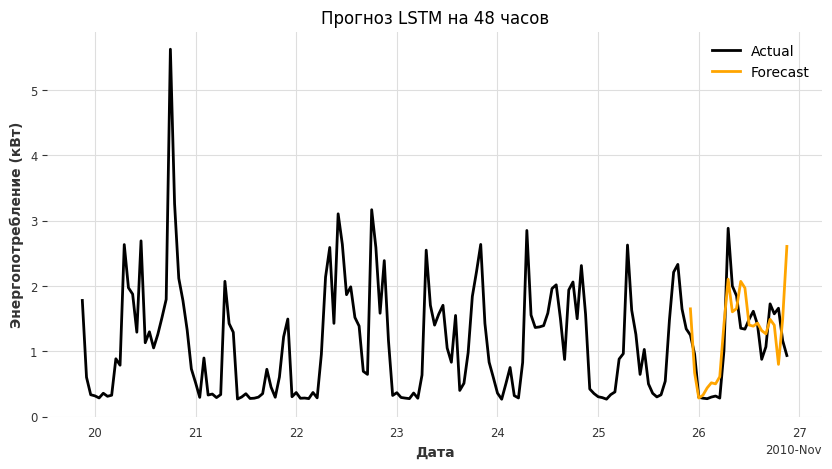

In [ ]:
plt.figure(figsize=(10,5))

actual.slice(
    actual.end_time() - pd.Timedelta(days=7),
    actual.end_time()
).plot(label="Actual", lw=2)

forecast.plot(label="Forecast", lw=2, color="orange")

plt.title("Прогноз LSTM на 48 часов")
plt.xlabel('Дата')
plt.ylabel('Энергопотребление (кВт)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Берём последние 48 точек из реальных значений
actual_last_48 = actual[-48:]

# Преобразуем в массивы
y_true = actual.slice(
    actual.end_time() - pd.Timedelta(hours=47),
    actual.end_time()
).values().flatten()
y_pred = forecast.values().flatten()
# Метрики
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAPE = {mape:.2f}%")

array([1.64971424, 0.67083982, 0.28367249, 0.32748816, 0.43917156,
       0.51682769, 0.50065118, 0.60974549, 1.41279944, 2.10424337,
       1.60430277, 1.65380221, 2.07072582, 1.96917844, 1.40183247,
       1.38426812, 1.43211687, 1.31637679, 1.26701143, 1.48933548,
       1.39974413, 0.79916751, 1.49391564, 2.60608948])